## Download the required data.

## Import Libraries

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import time

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader,Dataset,TensorDataset

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

data = pd.read_csv('./data/train_1.csv')

data.head()

# drop all na rows
data = data.dropna()

data = data.values
data = data[:,1:]  # remove the Page column
data = np.array(data, dtype=np.float)

## Time based train test split

X_train, y_train = data[:,:-60], data[:,-60:-30]
X_test, y_test   = data[:,30:-30], data[:,-30:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

## Code from https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Conv_Intro.ipynb
## An excellent blog post from Joseph Eddy

def prepare_train(series_array):
    '''normalizes the time series and outputs a numpy array of shape (num_samples, num_channels, timesteps)
    which can be used to pass into Neural Networks.'''
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],1, series_array.shape[1]))
    
    return series_array, series_mean

def prepare_test(series_array, encode_series_mean):
    '''uses the normalizing stats from train data to normalize test data
    and outputs a numpy array of shape (num_samples, num_channels, timesteps)
    which can be used to pass into Neural Networks.'''
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],1, series_array.shape[1]))
    
    return series_array

def save_model(m, p): torch.save(m.state_dict(), p)
def load_model(m, p): m.load_state_dict(torch.load(p))
    

def keep_notebook_alive(minutes=60):
    for min in range(1, minutes+1):
        time.sleep(60)
        print(f"{min} since start of sleep")

X_train, X_train_mean = prepare_train(X_train)  # for normalize for train data
X_test, X_test_mean = prepare_train(X_test)  # for normalizing test data

y_train = prepare_test(y_train, X_train_mean)
y_test = prepare_test(y_test, X_test_mean)

## Parameters 

batch_size = 1024
num_epochs = 10
learning_rate = 1e-3
criterion = nn.L1Loss()

# for dilated cnn model
num_filters = 32  # no. of filters to be used
kernel_size = 2  # kernel size 
input_channels = 1  # number of channels in the input 

## Pytorch Dataset Dataloader

X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size,shuffle=True)

test_dataloader = DataLoader(test_dataset, 
                              batch_size=batch_size,shuffle=False)

/data/nithish/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/data/nithish/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (117,121,126,129,245,248,252,369,379,383,384,502,506,512) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## CausalConv1d Block

In [2]:
# written by Roman Pearah(github username: https://github.com/neverfox) 
# code from https://github.com/pytorch/pytorch/issues/1333

class CausalConv1d(torch.nn.Conv1d):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dilation=1,
                 groups=1,
                 bias=True):

        super(CausalConv1d, self).__init__(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=0,
            dilation=dilation,
            groups=groups,
            bias=bias)
        
        self.__padding = (kernel_size - 1) * dilation
        
    def forward(self, input):
        return super(CausalConv1d, self).forward(F.pad(input, (self.__padding, 0)))

In [4]:
keep_notebook_alive(120)

KeyboardInterrupt: 

## Dilated CNN Architecture

In [3]:
class DilatedCNN(nn.Module):
    
    def __init__(self,):
        super(DilatedCNN, self).__init__()

        self.dil1 = CausalConv1d(in_channels=1,out_channels=32,kernel_size=2,
                                dilation=1)
        self.dil2 = CausalConv1d(in_channels=32,out_channels=32,kernel_size=2,
                                dilation=2)
        self.dil3 = CausalConv1d(in_channels=32,out_channels=32,kernel_size=2,
                                dilation=4)
        self.dil4 = CausalConv1d(in_channels=32,out_channels=32,kernel_size=2,
                                dilation=8)
        self.dil5 = CausalConv1d(in_channels=32,out_channels=16,kernel_size=2,
                                dilation=16)
        
        self.fc1 = nn.Linear(17,8)
        self.drop1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(8,1)
    
    def forward(self, x):
        
        # for predicting y0(y at timestep 0), we need to use
        # x-value at the last timestep.
        x_now = x.clone()[:,:,-1]
        x = torch.relu(self.dil1(x))
        x = torch.relu(self.dil2(x))
        x = torch.relu(self.dil3(x))
        x = torch.relu(self.dil4(x))
        x = torch.relu(self.dil5(x))
        
        x = x[:,:,-1]
        # batch_size, features, time_steps -> batch_size, features
        # take only the last timestep
        
        x = torch.cat([x,x_now], axis=1)
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = self.fc2(x)

        return x
        

In [4]:
net = DilatedCNN()
    
# optimizer
parameters = net.parameters()
optimizer = Adam(parameters, lr=0.01)
net = net.to(device)

total_parameters = sum(p.numel() for p in net.parameters())
print(f"total number of parameters = {total_parameters}")

total number of parameters = 7529


In [5]:
num_epochs = 100

In [7]:

train_losses = []

for num_epoch in tqdm(range(1, num_epochs+1)):
    epoch_loss = 0
    
    for batch in train_dataloader:
        x,y = batch
    
        x = x.to(device)
        y = y.to(device)
        out = net(x)
        y = y[:,:,-1]
        
        
        loss = criterion(out, y)
        epoch_loss += loss.item() * batch_size
        
        optimizer.zero_grad()  # clear buffer
        loss.backward()  # backprop loss
        optimizer.step()  # grad descent
    
    #normalize for train data
    epoch_loss /= len(train_dataset)
    
    print(f"train_loss = {epoch_loss}")
    
    


  1%|          | 1/100 [00:14<24:31, 14.86s/it]

train_loss = 0.4082705636536621



  2%|▏         | 2/100 [00:29<24:21, 14.91s/it]

train_loss = 0.40703105884227897



  3%|▎         | 3/100 [00:44<24:09, 14.94s/it]

train_loss = 0.4049962213328161



  4%|▍         | 4/100 [00:59<23:54, 14.94s/it]

train_loss = 0.4049742962239916



  5%|▌         | 5/100 [01:14<23:37, 14.93s/it]

train_loss = 0.40282925678277764



  6%|▌         | 6/100 [01:29<23:19, 14.89s/it]

train_loss = 0.4032890236293551



  7%|▋         | 7/100 [01:44<23:01, 14.86s/it]

train_loss = 0.402621964111453



  8%|▊         | 8/100 [01:59<22:45, 14.84s/it]

train_loss = 0.4007872546319686



  9%|▉         | 9/100 [02:13<22:29, 14.83s/it]

train_loss = 0.40096069890726854



 10%|█         | 10/100 [02:28<22:13, 14.82s/it]

train_loss = 0.4000278359574516



 11%|█         | 11/100 [02:43<21:54, 14.77s/it]

train_loss = 0.3992894974569372



 12%|█▏        | 12/100 [02:58<21:36, 14.73s/it]

train_loss = 0.3991608352476376



 13%|█▎        | 13/100 [03:12<21:19, 14.70s/it]

train_loss = 0.3991326567884267



 14%|█▍        | 14/100 [03:27<21:02, 14.68s/it]

train_loss = 0.3980338025285804



 15%|█▌        | 15/100 [03:41<20:42, 14.62s/it]

train_loss = 0.398471384046185



 16%|█▌        | 16/100 [03:56<20:32, 14.68s/it]

train_loss = 0.3969574973854745



 17%|█▋        | 17/100 [04:11<20:18, 14.68s/it]

train_loss = 0.39639140562713704



 18%|█▊        | 18/100 [04:25<19:58, 14.62s/it]

train_loss = 0.396423451998634



 19%|█▉        | 19/100 [04:39<19:34, 14.49s/it]

train_loss = 0.3965210488663961



 20%|██        | 20/100 [04:54<19:12, 14.41s/it]

train_loss = 0.3957631961967322



 21%|██        | 21/100 [05:08<18:52, 14.33s/it]

train_loss = 0.3945197178236829



 22%|██▏       | 22/100 [05:22<18:34, 14.29s/it]

train_loss = 0.39593915263734497



 23%|██▎       | 23/100 [05:36<18:19, 14.27s/it]

train_loss = 0.39465370023391666



 24%|██▍       | 24/100 [05:50<18:03, 14.25s/it]

train_loss = 0.3945837452514195



 25%|██▌       | 25/100 [06:05<17:46, 14.22s/it]

train_loss = 0.3941282142684178



 26%|██▌       | 26/100 [06:19<17:31, 14.21s/it]

train_loss = 0.39427519727726623



 27%|██▋       | 27/100 [06:33<17:17, 14.21s/it]

train_loss = 0.3935270841273171



 28%|██▊       | 28/100 [06:47<17:01, 14.19s/it]

train_loss = 0.393586101016096



 29%|██▉       | 29/100 [07:01<16:47, 14.19s/it]

train_loss = 0.3929578067539228



 30%|███       | 30/100 [07:16<16:33, 14.19s/it]

train_loss = 0.39315071549632385



 31%|███       | 31/100 [07:30<16:27, 14.31s/it]

train_loss = 0.39195363853925846



 32%|███▏      | 32/100 [07:45<16:17, 14.37s/it]

train_loss = 0.3918723566941413



 33%|███▎      | 33/100 [07:59<16:13, 14.53s/it]

train_loss = 0.39250842607412884



 34%|███▍      | 34/100 [08:14<16:07, 14.66s/it]

train_loss = 0.39245368382172785



 35%|███▌      | 35/100 [08:29<15:55, 14.70s/it]

train_loss = 0.3927506894709782



 36%|███▌      | 36/100 [08:44<15:42, 14.72s/it]

train_loss = 0.392355208971185



 37%|███▋      | 37/100 [08:59<15:29, 14.76s/it]

train_loss = 0.3915859682871662



 38%|███▊      | 38/100 [09:14<15:18, 14.82s/it]

train_loss = 0.3917211617619707



 39%|███▉      | 39/100 [09:29<15:05, 14.84s/it]

train_loss = 0.39152244152299515



 40%|████      | 40/100 [09:44<14:49, 14.83s/it]

train_loss = 0.3910191978746817



 41%|████      | 41/100 [09:58<14:37, 14.87s/it]

train_loss = 0.39097326381408426



 42%|████▏     | 42/100 [10:14<14:25, 14.92s/it]

train_loss = 0.39107816271943097



 43%|████▎     | 43/100 [10:28<14:10, 14.92s/it]

train_loss = 0.39033690715105285



 44%|████▍     | 44/100 [10:43<13:55, 14.91s/it]

train_loss = 0.39022156535093033



 45%|████▌     | 45/100 [10:58<13:41, 14.93s/it]

train_loss = 0.38998010135037686



 46%|████▌     | 46/100 [11:13<13:26, 14.94s/it]

train_loss = 0.3900741436109117



 56%|█████▌    | 56/100 [13:39<10:37, 14.50s/it]

train_loss = 0.38879378215446697



 57%|█████▋    | 57/100 [13:54<10:26, 14.57s/it]

train_loss = 0.3902041704146695



 58%|█████▊    | 58/100 [14:09<10:15, 14.67s/it]

train_loss = 0.3881710844470256



 59%|█████▉    | 59/100 [14:24<10:02, 14.70s/it]

train_loss = 0.389107575906592



 60%|██████    | 60/100 [14:38<09:41, 14.55s/it]

train_loss = 0.38862471868536547



 61%|██████    | 61/100 [14:52<09:23, 14.44s/it]

train_loss = 0.3895816551215522



 62%|██████▏   | 62/100 [15:06<09:07, 14.40s/it]

train_loss = 0.3883224344704046



 63%|██████▎   | 63/100 [15:21<08:52, 14.39s/it]

train_loss = 0.3880416837329449



 64%|██████▍   | 64/100 [15:35<08:41, 14.49s/it]

train_loss = 0.38773655557198206



 65%|██████▌   | 65/100 [15:50<08:30, 14.60s/it]

train_loss = 0.3877351488218597



 66%|██████▌   | 66/100 [16:05<08:19, 14.68s/it]

train_loss = 0.38808374545751384



 67%|██████▋   | 67/100 [16:19<08:00, 14.55s/it]

train_loss = 0.3876156333507768



 68%|██████▊   | 68/100 [16:34<07:48, 14.65s/it]

train_loss = 0.3871177861479011



 69%|██████▉   | 69/100 [16:49<07:34, 14.67s/it]

train_loss = 0.38801725634717327



 70%|███████   | 70/100 [17:04<07:20, 14.67s/it]

train_loss = 0.3871283854349862



 71%|███████   | 71/100 [17:18<07:05, 14.68s/it]

train_loss = 0.3871162451241822



 72%|███████▏  | 72/100 [17:33<06:50, 14.68s/it]

train_loss = 0.38829965948257544



 73%|███████▎  | 73/100 [17:48<06:36, 14.69s/it]

train_loss = 0.3870848948415823



 74%|███████▍  | 74/100 [18:02<06:22, 14.69s/it]

train_loss = 0.3874618565142937



 75%|███████▌  | 75/100 [18:17<06:05, 14.62s/it]

train_loss = 0.38693606999452346



 76%|███████▌  | 76/100 [18:31<05:47, 14.49s/it]

train_loss = 0.38706408998049674



 77%|███████▋  | 77/100 [18:45<05:31, 14.40s/it]

train_loss = 0.3866568407642715



 78%|███████▊  | 78/100 [18:59<05:15, 14.33s/it]

train_loss = 0.38712439730099163



 79%|███████▉  | 79/100 [19:14<05:00, 14.29s/it]

train_loss = 0.38701292887777816



 80%|████████  | 80/100 [19:28<04:45, 14.26s/it]

train_loss = 0.38667043674658563



 81%|████████  | 81/100 [19:42<04:31, 14.30s/it]

train_loss = 0.3864794127787195



 82%|████████▏ | 82/100 [19:57<04:19, 14.41s/it]

train_loss = 0.38628683321480617



 83%|████████▎ | 83/100 [20:12<04:06, 14.49s/it]

train_loss = 0.3876190784053216



 84%|████████▍ | 84/100 [20:26<03:52, 14.51s/it]

train_loss = 0.38646750302296706



 85%|████████▌ | 85/100 [20:40<03:36, 14.42s/it]

train_loss = 0.3876305593182695



 86%|████████▌ | 86/100 [20:54<03:20, 14.34s/it]

train_loss = 0.3869481366630254



 87%|████████▋ | 87/100 [21:09<03:05, 14.29s/it]

train_loss = 0.38725733414666913



 88%|████████▊ | 88/100 [21:23<02:51, 14.27s/it]

train_loss = 0.3873486961396753



 89%|████████▉ | 89/100 [21:37<02:37, 14.31s/it]

train_loss = 0.3864514081465677



 90%|█████████ | 90/100 [21:51<02:22, 14.26s/it]

train_loss = 0.38522742468637683



 91%|█████████ | 91/100 [22:06<02:08, 14.24s/it]

train_loss = 0.38595520787701126



 92%|█████████▏| 92/100 [22:20<01:53, 14.22s/it]

train_loss = 0.38551944659934484



 93%|█████████▎| 93/100 [22:34<01:39, 14.21s/it]

train_loss = 0.38545369365180415



 94%|█████████▍| 94/100 [22:48<01:25, 14.20s/it]

train_loss = 0.386522490662968



 95%|█████████▌| 95/100 [23:02<01:10, 14.20s/it]

train_loss = 0.38581444204794874



 96%|█████████▌| 96/100 [23:17<00:56, 14.20s/it]

train_loss = 0.38544537623520053



 97%|█████████▋| 97/100 [23:31<00:42, 14.18s/it]

train_loss = 0.385706206339639



 98%|█████████▊| 98/100 [23:45<00:28, 14.19s/it]

train_loss = 0.3858730022503672



 99%|█████████▉| 99/100 [23:59<00:14, 14.19s/it]

train_loss = 0.38566203344900596



100%|██████████| 100/100 [24:14<00:00, 14.54s/it]

train_loss = 0.38522893942786074


In [102]:
out = net(x)

## GRU model

In [134]:
class GRU_model(nn.Module):
    
    def __init__(self):
        super(GRU_model, self).__init__()
        self.gru1 = nn.GRU(input_size=1,hidden_size=16,num_layers=2,batch_first=True)
        self.fc1 = nn.Linear(16,8)
        self.fc2 = nn.Linear(8,1)
    
    def forward(self,x):
        x = x.transpose(1,2)
        x,l = self.gru1(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [9]:
## Teacher forcing during training
## Training

In [274]:
net = DilatedCNN()
    
# optimizer
parameters = net.parameters()
optimizer = Adam(parameters, lr=0.01)
net = net.to(device)

total_parameters = sum(p.numel() for p in net.parameters())
print(f"total number of parameters = {total_parameters}")

total number of parameters = 31681


> To keep the neural network training simple we will only monitor the training loss

In [275]:

train_losses = []

for num_epoch in tqdm(range(1, num_epochs+1)):
    epoch_loss = 0
    for batch in train_dataloader:
        x,y = batch
        y_lag = y.clone()[:,:,:-1]
        # append y history to x
        
        x = torch.cat([x,y_lag], axis=2)
        
        x = x.to(device)
        y = y.to(device)
        out = net(x)
        
        out = out[:,-29:,:]  # only use last 29 timesteps
                             # 
        y = y.transpose(1,2)
        y = y[:,-29:,:]
        
        loss = criterion(out, y)
        epoch_loss += loss.item() * batch_size
        
        optimizer.zero_grad()  # clear buffer
        loss.backward()  # backprop loss
        optimizer.step()  # grad descent
    
    #normalize for train data
    epoch_loss /= len(train_dataset)
    
    print(f"train_loss = {epoch_loss}")
    
    









  0%|          | 0/10 [00:00<?, ?it/s]







 10%|█         | 1/10 [00:11<01:46, 11.78s/it]

train_loss = 0.4970574490374036










 20%|██        | 2/10 [00:23<01:33, 11.72s/it]

train_loss = 0.4782580635208457










 30%|███       | 3/10 [00:34<01:21, 11.68s/it]

train_loss = 0.47107089543684944










 40%|████      | 4/10 [00:46<01:09, 11.65s/it]

train_loss = 0.4658673530166685










 50%|█████     | 5/10 [00:58<00:58, 11.63s/it]

train_loss = 0.46143920028261326










 60%|██████    | 6/10 [01:09<00:46, 11.62s/it]

train_loss = 0.4568758863410519










 70%|███████   | 7/10 [01:21<00:34, 11.58s/it]

train_loss = 0.45381640389344635










 80%|████████  | 8/10 [01:32<00:23, 11.56s/it]

train_loss = 0.45282259113958806










 90%|█████████ | 9/10 [01:44<00:11, 11.54s/it]

train_loss = 0.4512581949674106










100%|██████████| 10/10 [01:55<00:00, 11.57s/it]

train_loss = 0.4510472847155828


In [ ]:
# save_model(net, 'models/gru.pt')

In [49]:
# save_model(net, 'models/dilated-cnn.pt')

> load model from saved weights

In [10]:
net = DilatedCNN()
load_model(net, 'models/dilated-cnn.pt')

In [11]:
dl1 = iter(train_dataloader)

In [12]:
x,y = next(dl1)

In [13]:
x.shape, y.shape

(torch.Size([1024, 1, 490]), torch.Size([1024, 1, 30]))

In [14]:
out = net(x)

In [ ]:
out.shape, y.shape

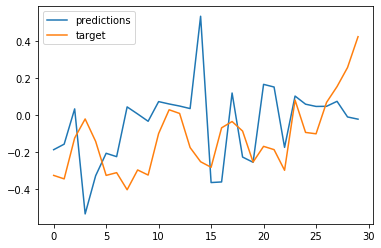

In [20]:
plot_predictions(out[:,-30:,:],y,1)

## Prediction Stage

In [129]:
test_dataloader = DataLoader(test_dataset, 
                              batch_size=64,shuffle=False)

In [130]:
dl = iter(test_dataloader)
x,y = next(dl)
net.eval()

DilatedCNN(
  (casual_cnn_block): Sequential(
    (0): CausalConv1d(1, 32, kernel_size=(2,), stride=(1,))
    (1): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), dilation=(2,))
    (2): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), dilation=(4,))
    (3): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), dilation=(8,))
    (4): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), dilation=(16,))
    (5): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), dilation=(32,))
    (6): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), dilation=(64,))
    (7): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), dilation=(128,))
  )
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)

In [131]:
x.shape

torch.Size([64, 1, 490])

In [69]:
x = x.to(device)

In [70]:
net = net.to(device)

In [113]:
net.eval()

DilatedCNN(
  (casual_cnn_block): Sequential(
    (0): CausalConv1d(1, 32, kernel_size=(2,), stride=(1,))
    (1): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), dilation=(2,))
    (2): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), dilation=(4,))
    (3): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), dilation=(8,))
    (4): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), dilation=(16,))
    (5): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), dilation=(32,))
    (6): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), dilation=(64,))
    (7): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), dilation=(128,))
  )
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)

In [114]:
out1 = net(x)
out1 = out1.transpose(1,2)
out1 = out1[:,:,-1:]

In [119]:
out1

tensor([[[ 0.0943]],

        [[ 0.1467]],

        [[-0.1412]],

        [[ 0.0715]],

        [[ 0.0864]],

        [[ 0.0122]],

        [[ 0.1036]],

        [[ 0.0916]],

        [[ 0.0451]],

        [[ 0.1099]],

        [[ 0.0276]],

        [[ 0.1805]],

        [[-0.0433]],

        [[-0.0148]],

        [[-0.1614]],

        [[ 0.1728]],

        [[-0.1013]],

        [[-0.0373]],

        [[ 0.0252]],

        [[ 0.0039]],

        [[ 0.0679]],

        [[ 0.0009]],

        [[-0.0658]],

        [[ 0.0550]],

        [[ 0.0935]],

        [[-0.0316]],

        [[ 0.2146]],

        [[-0.1002]],

        [[-0.0615]],

        [[ 0.0398]],

        [[-0.0054]],

        [[-0.3795]],

        [[ 0.1388]],

        [[-0.0035]],

        [[ 0.0973]],

        [[ 0.0608]],

        [[ 0.0151]],

        [[-0.0350]],

        [[-0.0099]],

        [[ 0.1477]],

        [[ 0.0628]],

        [[ 0.0694]],

        [[-0.0651]],

        [[ 0.0260]],

        [[-0.3315]],

        [[

In [121]:
x1 = torch.cat([x,out1], axis=2)

In [122]:
out2 = net(x1).transpose(1,2)[:,:,-1:]

In [126]:
out1[0,0,0]

tensor(0.0943, device='cuda:0', grad_fn=<SelectBackward>)

In [125]:
out2[0,0,0]

tensor(0.0727, device='cuda:0', grad_fn=<SelectBackward>)

In [127]:
x11 = x1[:,:,-200:]
out3 = net(x11).transpose(1,2)[:,:,-1:]
out3


tensor([[[-0.3055]],

        [[-0.4639]],

        [[-0.2166]],

        [[-0.4959]],

        [[-0.2089]],

        [[-0.1339]],

        [[-0.4166]],

        [[-0.3674]],

        [[-0.2777]],

        [[-0.3015]],

        [[-0.4117]],

        [[-0.4126]],

        [[-0.3828]],

        [[-0.4347]],

        [[-0.4994]],

        [[-0.1084]],

        [[-0.3905]],

        [[-0.3507]],

        [[-0.4019]],

        [[-0.4384]],

        [[-0.4122]],

        [[-0.2676]],

        [[-0.2427]],

        [[-0.2089]],

        [[-0.3549]],

        [[-0.5073]],

        [[-0.4907]],

        [[-0.4440]],

        [[-0.5113]],

        [[-0.2668]],

        [[-0.4993]],

        [[-0.6791]],

        [[-0.2399]],

        [[-0.2750]],

        [[-0.3871]],

        [[-0.4873]],

        [[-0.3950]],

        [[-0.3263]],

        [[-0.4301]],

        [[-0.1258]],

        [[-0.2752]],

        [[-0.3128]],

        [[-0.3400]],

        [[-0.2965]],

        [[-0.3988]],

        [[

In [128]:
out3[0,0,0]

tensor(-0.3055, device='cuda:0', grad_fn=<SelectBackward>)

In [132]:
def predict_sequence(net, x, predict_len=30,device=device):
    '''
    Input Args:
        
        net = trained model
        input_sequence = input_sequence for which we need to forest
        predict_len = forecast these many values after the end
                      of input_sequence
                      
    '''
    batch_size, features, timesteps = x.size()
    predictions = []
    net.eval()
    for i in range(predict_len):
        
        x = x[:,:,-490:]
        predict = net(x) #  predict for 1 time step at a time
        predict = predict[:,-1:,:]  # last time step
        predictions.append(predict)
    
        x = torch.cat([x,predict], axis=2)
#         print(x.shape)
    
    predictions = [i.squeeze(2) for i in predictions]
    predictions = torch.cat(predictions, axis=1)
    return predictions

In [136]:
net.eval()
for batch in test_dataloader:
    x,y = batch
    x = x.to(device)
    y = y.to(device)
    y_pred = predict_sequence(net, x, device=device)
    break

In [147]:
y.shape, y_pred.shape

(torch.Size([64, 1, 30]), torch.Size([64, 30]))

In [150]:
y_pred = y_pred.unsqueeze(1)

In [153]:
criterion(y_pred, y)

tensor(0.4252, device='cuda:0', grad_fn=<L1LossBackward>)

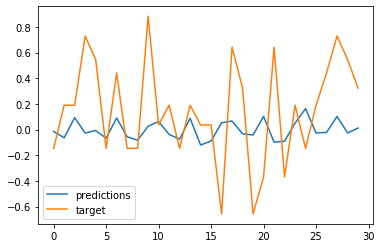

In [157]:
plot_predictions(y_pred, y, 50)

In [17]:
def _to_numpy(t): return t.detach().cpu().numpy()
def plot_predictions(y_pred, y,idx):
    
    preds = y_pred[idx,:,:]
    target = y[idx,:,:]
    
    preds = _to_numpy(preds).ravel()
    target = _to_numpy(target).ravel()
    
    xaxis = range(len(preds))

    sns.lineplot(x=xaxis, y=preds,label='predictions')
    sns.lineplot(x=xaxis, y=target,label='target')
    

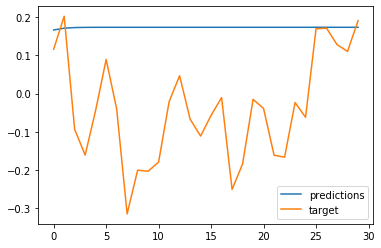

In [93]:
plot_predictions(y_pred, y, 50)